<a href="https://colab.research.google.com/github/amitkumar/reciprocity-nlp/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
!pip install --quiet sentence-transformers==1.2.0
!pip install --quiet umap-learn[plot]==0.5.1
!pip install --quiet hdbscan==0.8.26

     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 2.3MB 27.2MB/s 
     |████████████████████████████████| 1.2MB 40.6MB/s 
     |████████████████████████████████| 901kB 20.4MB/s 
     |████████████████████████████████| 3.3MB 37.4MB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 1.2MB 34.9MB/s 
     |████████████████████████████████| 15.8MB 228kB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 706kB 43.7MB/s 
     |████████████████████████████████| 112kB 54.7MB/s 
ERROR: distributed 2021.5.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.5.0 has requirement dask==2021.05.0, but you'll have dask 2.12.0 which is incompatible.
     |████████████████████████████████| 4.7MB 23.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing

In [ ]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# !pip install --quiet umap
!pip install --quiet gensim
!pip install --quiet matplotlib
!pip install --quiet seaborn

In [ ]:
# !pip install --upgrade torch

     |████████████████████████████████| 119.5 MB 2.7 MB/s eta 0:00:012
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0


In [ ]:
# !pip install pandas==1.1.5
# !pip install numpy==1.19.5
!pip install pyLDAvis

In [ ]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X

In [ ]:
df = pd.read_csv("asks.csv")

In [ ]:
df.head()

,__v,_id,body,communities,createdAt,desiredResponseType,followers,isActive,lookingFor,owner,repliesSearchBlob,sentToSlacks,tags,updatedAt,upvotes,visibility
0,5,5be9bbf1e8440d56f772cd16,Looking for advice on how to do a friends-and-family fundraising round for a startup.,"[{""$oid"":""5bc8933342fc75b1f8cb4d36""}]",2018-11-12T17:44:17.606Z,quick-reply,"[{""$oid"":""5d9cd884c138fc005e032d94""},{""$oid"":""5bfdc12c7c6f2b001d1435b4""},{""$oid"":""5be90dfbab55f1001d99024d""}]",True,advice,5bc8933542fc75b1f8cb4d38,i can help! cool i can help happy to chat,[],"[""startups""]",2019-12-11T02:57:04.221Z,"[{""$oid"":""5be90dfbab55f1001d99024d""}]",specific-communities
1,1,5bec5e1d5c0fbf001d4ed176,Sales pitch coaching,"[{""$oid"":""5bc8933342fc75b1f8cb4d36""}]",2018-11-14T17:40:45.134Z,chat,[],True,advice,5beb303501d7a2001d44e479,NaN,[],"[""coaching"",""sales""]",2018-11-14T17:40:45.134Z,[],specific-communities
2,3,5bed00802bb378001d84ab9f,"I would like advice on bettering my career options and opening more roads. I have a Bachelors in Psychology, and am looking to pursue a Masters degree in Applied Psychology. I would like advice on...","[{""$oid"":""5be7f9fb765dd919cbf2b349""}]",2018-11-15T05:13:36.494Z,quick-reply,"[{""$oid"":""5c64c8a2d01619007795ec90""},{""$oid"":""5be90dfbab55f1001d99024d""}]",True,advice,5beb0693f7d184001de5f110,"hi maria i have a few contacts that may be useful for you, feel free to mssg me if you'd like to be connected! hi maria, \nhave a look at ciis located in san francisco. \nhttps://www.ciis.edu\nor ...",[],"[""career advice""]",2019-12-11T02:56:59.683Z,[],specific-communities
3,2,5bfcc04f9ac565001d95b7a4,I'm hoping to find a connection to someone who idetifies the same way I do and for them to share their professional experiences on how I too may advance in my professional and academic career.,"[{""$oid"":""5be7f9fb765dd919cbf2b349""}]",2018-11-27T03:55:59.815Z,chat,"[{""$oid"":""5cffe8c7fcf88d00684add3e""}]",True,connection,5bfcbfd99ac565001d95b678,"hi crystal, \n\ni would love to connect after reading your message! some days i feel like it would be nice to sit down and chit chat about my professional life and career, and where i would like f...",[],"[""connections"",""advice"",""mentorship"",""academic adivce"",""professional advice"",""mba application advice""]",2019-06-14T06:56:57.665Z,[],specific-communities
4,4,5be9a38eb6619e001d47acc9,Best coworking spaces near Palo Alto,"[{""$oid"":""5bc8933342fc75b1f8cb4d36""}]",2018-11-12T16:00:14.970Z,quick-reply,"[{""$oid"":""5dd772ccb67fc2005d208f52""}]",True,advice,5be90dfbab55f1001d99024d,NaN,[],[],2020-04-05T06:10:56.557Z,"[{""$oid"":""5be90dfbab55f1001d99024d""},{""$oid"":""5bc89373999a1a7c8a2e7c22""}]",specific-communities


In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [ ]:
# remove unwanted characters, numbers and symbols
df['body'] = df['body'].str.replace("[^a-zA-Z#]", " ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['body'] = df['body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['body']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

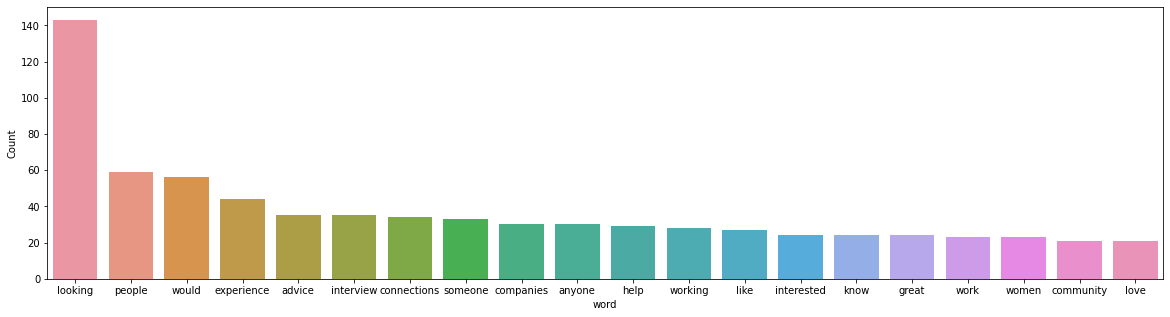

In [ ]:
freq_words(reviews, 20)

In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['sales', 'pitch', 'coaching']


In [ ]:
print(tokenized_reviews[2])

['would', 'like', 'advice', 'bettering', 'career', 'options', 'opening', 'roads', 'bachelors', 'psychology', 'looking', 'pursue', 'masters', 'degree', 'applied', 'psychology', 'would', 'like', 'advice', 'anything', 'help', 'along', 'way']


In [ ]:
reviews_2 = lemmatization(tokenized_reviews)

In [ ]:
print(reviews_2[1]) # print lemmatized review

['sale', 'pitch', 'coaching']


In [ ]:
print(reviews_2[2])

['advice', 'career', 'option', 'road', 'bachelor', 'psychology', 'pursue', 'master', 'degree', 'psychology', 'advice', 'help', 'way']


As you can see, we have not just lemmatized the words but also filtered only nouns and adjectives. Let’s de-tokenize the lemmatized reviews and plot the most common words

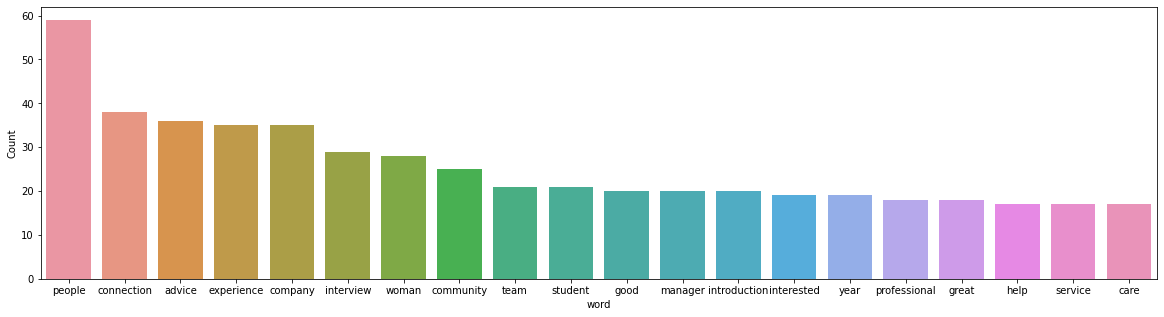

In [ ]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['body'] = reviews_3

freq_words(df['body'], 20)

In [ ]:
dictionary = corpora.Dictionary(reviews_2)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [ ]:
lda_model.print_topics()

[(0,
  '0.013*"interview" + 0.012*"step" + 0.011*"willing" + 0.010*"industry" + 0.009*"connection" + 0.008*"people" + 0.008*"partner" + 0.008*"next" + 0.008*"world" + 0.008*"year"'),
 (1,
  '0.032*"advice" + 0.019*"people" + 0.018*"woman" + 0.013*"experience" + 0.011*"role" + 0.010*"team" + 0.010*"career" + 0.008*"technology" + 0.008*"year" + 0.008*"new"'),
 (2,
  '0.030*"connection" + 0.028*"social" + 0.019*"people" + 0.014*"expert" + 0.010*"woman" + 0.010*"brand" + 0.010*"app" + 0.010*"medium" + 0.010*"thank" + 0.008*"friend"'),
 (3,
  '0.020*"company" + 0.020*"people" + 0.018*"community" + 0.016*"good" + 0.012*"manager" + 0.011*"online" + 0.010*"friend" + 0.010*"trucking" + 0.010*"advice" + 0.009*"employee"'),
 (4,
  '0.017*"people" + 0.016*"experience" + 0.011*"interview" + 0.011*"introduction" + 0.010*"student" + 0.010*"executive" + 0.010*"senior" + 0.009*"business" + 0.009*"woman" + 0.007*"contact"'),
 (5,
  '0.018*"product" + 0.017*"job" + 0.015*"company" + 0.014*"help" + 0.014*

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.020692 -0.024726       1        1  18.468724
3     -0.047020  0.123525       2        1  17.586616
1     -0.099826  0.013288       3        1  15.809766
5     -0.021617  0.052475       4        1  14.158737
0     -0.003618 -0.114090       5        1  12.533247
2      0.006337 -0.093027       6        1  11.882350
6      0.186437  0.042556       7        1   9.560560, topic_info=           Term       Freq      Total Category  logprob  loglift
20   connection  27.000000  27.000000  Default  30.0000  30.0000
362        care  12.000000  12.000000  Default  29.0000  29.0000
48       social  11.000000  11.000000  Default  28.0000  28.0000
0        advice  27.000000  27.000000  Default  27.0000  27.0000
380       great  13.000000  13.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
358     student   2.109938  16.417065   Topic7  -4.9195   0.2959
90       people   1.547051  44.960571   Topic7  -5.2298  -1.0219
278     partner   1.438808   6.454273   Topic7  -5.3023   0.8466
66     personal   1.438591   6.569499   Topic7  -5.3025   0.8288
67      process   1.438545   8.849950   Topic7  -5.3025   0.5307

[439 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
879       4  0.902483            able
19        6  0.695267        academic
228       4  0.902498  accountability
453       1  0.338117           adult
453       5  0.676234           adult
...     ...       ...             ...
198       1  0.198762            year
198       2  0.265016            year
198       3  0.265016            year
198       4  0.066254            year
198       5  0.198762            year

[703 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 6, 1, 3, 7])

In [ ]:
!pip install spikex

In [ ]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7MB 25.7MB/s 
     |████████████████████████████████| 122kB 19.8MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=e1fc58bbdb01057b2030855079568bcf8c4d3207d2655cacec98f8a6376178a1
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
  Found existing installation: smart-open 5.0.0
    Uninstalling smart-open-5.0.0:
      Successfully uninstalled smart-open-5.0.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!spikex download-wikigraph simplewiki_core

--2021-05-27 14:11:14--  https://errequadrosrl-my.sharepoint.com/:u:/g/personal/paolo_arduin_errequadrosrl_onmicrosoft_com/EbwV-u0YtVdNo4f02X7HbDsBs3BRTEu4ix-_n0JYLKOJzQ?Download=1
Resolving errequadrosrl-my.sharepoint.com (errequadrosrl-my.sharepoint.com)... 40.108.211.41
Connecting to errequadrosrl-my.sharepoint.com (errequadrosrl-my.sharepoint.com)|40.108.211.41|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/paolo_arduin_errequadrosrl_onmicrosoft_com/Documents/spikex/wikigraphs/simplewiki_core-20210401.tar.gz?originalPath=aHR0cHM6Ly9lcnJlcXVhZHJvc3JsLW15LnNoYXJlcG9pbnQuY29tLzp1Oi9nL3BlcnNvbmFsL3Bhb2xvX2FyZHVpbl9lcnJlcXVhZHJvc3JsX29ubWljcm9zb2Z0X2NvbS9FYndWLXUwWXRWZE5vNGYwMlg3SGJEc0JzM0JSVEV1NGl4LV9uMEpZTEtPSnpRP3J0aW1lPURhTkpTaGtoMlVn [following]
--2021-05-27 14:11:15--  https://errequadrosrl-my.sharepoint.com/personal/paolo_arduin_errequadrosrl_onmicrosoft_com/Documents/spikex/wikigraphs/simplewiki_core-20210401.tar.gz?originalPath=aHR0cHM6

In [ ]:
from spacy import load as spacy_load
from spikex.wikigraph import load as wg_load
from spikex.pipes import WikiPageX

# load a spacy model and get a doc
nlp = spacy_load('en_core_web_sm')
doc = nlp('Looking for advice on how to do a friends-and-family fundraising round for a startup')
# load a WikiGraph
wg = wg_load('simplewiki_core')
# get a WikiPageX and extract all pages
wikipagex = WikiPageX(wg)
doc = wikipagex(doc)
# see all pages extracted from the doc
for span in doc._.wiki_spans:
   print(span._.wiki_pages)

('Advice_(constitutional)', 'Advice')
('How_to',)
('To',)
('Do', 'Do')
('A', 'A_(Cyrillic)', 'A_(New_York_City_Subway_service)', 'A_(musical_note)', 'A_(New_York_City_Subway_service)', 'A_(disambiguation)')
('Friend', 'Friend_(2001_movie)', 'Friend_(2001_film)', 'Friend', 'Friend_(2001_film)')
('And_(disambiguation)', 'And_(logic)', 'And_(disambiguation)', 'And_(logic)', 'And')
('Family', 'Family_(biology)', 'Family_(taxonomy)', 'Family_(taxonomy)')
('Fundraising',)
('Round_(music)', 'Round')
('A', 'A_(Cyrillic)', 'A_(New_York_City_Subway_service)', 'A_(musical_note)', 'A_(New_York_City_Subway_service)', 'A_(disambiguation)')


In [ ]:
from spacy import load as spacy_load
from spikex.pipes import ClusterX

nlp = spacy_load("en_core_web_sm")
doc = nlp("Sales pitch coaching")
clusterx = ClusterX(min_score=0.65)
try:
  doc = clusterx(doc)
  print(doc)
  for cluster in doc._.cluster_chunks:
    print(cluster)
except:
  cluster = None

In [ ]:
df['body'][0]

'Looking for advice on how to do a friends-and-family fundraising round for a startup.'

In [ ]:
def generate_clusters(n):
  #print(n)
  clusters = []
  doc = nlp(n)
  clusterx = ClusterX(min_score=0.65)
  try:
    doc = clusterx(doc)
    for cluster in doc._.cluster_chunks:
      clusters.append(cluster)
  except:
    clusters = None
  print(clusters)
  return clusters

In [ ]:
# def replace(row):
#   for i, item in enumerate(row):
#     print(item)
#     break
#     row[i]=generate_clusters(item)
#   return row

In [ ]:
data=pd.DataFrame(data=df['body'],columns=['body'])
data.head()

,body
0,Looking for advice on how to do a friends-and-family fundraising round for a startup.
1,Sales pitch coaching
2,"I would like advice on bettering my career options and opening more roads. I have a Bachelors in Psychology, and am looking to pursue a Masters degree in Applied Psychology. I would like advice on..."
3,I'm hoping to find a connection to someone who idetifies the same way I do and for them to share their professional experiences on how I too may advance in my professional and academic career.
4,Best coworking spaces near Palo Alto


In [ ]:
data.size

393

In [ ]:
data.dropna(subset = ["body"], inplace=True)

In [ ]:
data.size

393

In [ ]:
data_sample = [generate_clusters(x) for x in data['body']]
data_sample[0]

[[advice], [a startup], [a friends-and-family fundraising round]]
None
[[I], [me], [anything], [Psychology], [a Bachelors], [advice], [Applied Psychology], [my career options], [the way], [more roads], [a Masters degree]]
[[I], [who], [them], [someone], [their professional experiences], [a connection], [my professional and academic career]]
[[Best coworking spaces], [Palo Alto]]
[[Growth equity investors], [a lean operator/ investor private equity model], [cap deals], [-], [mid]]
[[others], [sales], [the areas], [bouncing ideas], [each other's businesses], [online, social media practices], [marketing], [the Social Selling & Social Media practitioner/leader space]]
[[leadership development programs], [the future]]
[[I], [it], [me], [anything], [this screen], [the community], [an ask]]
[[Connections], [mission driven companies/startups], [environment], [potential opportunities], [food], [the areas], [work], ['future]]
[[Examples], [workers, networks, employees], [you], [personal values],

[[advice], [a startup], [a friends-and-family fundraising round]]

In [ ]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [ ]:
import itertools

In [ ]:
data['categories'] = pd.Series(data_sample)

In [ ]:
data.head(10)

,body,categories
0,Looking for advice on how to do a friends-and-family fundraising round for a startup.,"[[(advice)], [(a, startup)], [(a, friends, -, and, -, family, fundraising, round)]]"
1,Sales pitch coaching,None
2,"I would like advice on bettering my career options and opening more roads. I have a Bachelors in Psychology, and am looking to pursue a Masters degree in Applied Psychology. I would like advice on...","[[(I)], [(me)], [(anything)], [(Psychology)], [(a, Bachelors)], [(advice)], [(Applied, Psychology)], [(my, career, options)], [(the, way)], [(more, roads)], [(a, Masters, degree)]]"
3,I'm hoping to find a connection to someone who idetifies the same way I do and for them to share their professional experiences on how I too may advance in my professional and academic career.,"[[(I)], [(who)], [(them)], [(someone)], [(their, professional, experiences)], [(a, connection)], [(my, professional, and, academic, career)]]"
4,Best coworking spaces near Palo Alto,"[[(Best, coworking, spaces)], [(Palo, Alto)]]"
5,Growth equity investors interested small to mid-cap deals through a lean operator/ investor private equity model.,"[[(Growth, equity, investors)], [(a, lean, operator/, investor, private, equity, model)], [(cap, deals)], [(-)], [(mid)]]"
6,"to others in the Social Selling & Social Media practitioner/leader space. Interested in sharing and bouncing ideas off each other's businesses, especially in the areas of marketing & sales relatin...","[[(others)], [(sales)], [(the, areas)], [(bouncing, ideas)], [(each, other, 's, businesses)], [(online, ,, social, media, practices)], [(marketing)], [(the, Social, Selling, &, Social, Media, prac..."
7,to talk to about leadership development programs of the future.,"[[(leadership, development, programs)], [(the, future)]]"
8,I'm not ready to ask for anything yet but wanted to check out the community and it won't let me through this screen without making an ask.,"[[(I)], [(it)], [(me)], [(anything)], [(this, screen)], [(the, community)], [(an, ask)]]"
9,"Connections and potential opportunities with mission driven companies/startups especially in the areas of food; environment, and 'future of work'","[[(Connections)], [(mission, driven, companies, /, startups)], [(environment)], [(potential, opportunities)], [(food)], [(the, areas)], [(work)], [(', future)]]"
